# Anime Recommender System Using Hybrid Filter
<b>Muhammed Rüşen Birben 150220755</b>

## <b>1 - Data Preparing and Understanding</b>

### <b>1.a Preparing Anime Info Dataframes</b>

#### Importing pandas and reading anime csv files

In [57]:
import pandas as pd
import numpy as np
anime_synopsis = pd.read_csv("data_raw/data/anime_with_synopsis.csv")
anime_df = pd.read_csv("data_raw/data/anime.csv")

#### Getting info for both dfs

In [58]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [ ]:
anime_synopsis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MAL_ID     16214 non-null  int64 
 1   Name       16214 non-null  object
 2   Score      16214 non-null  object
 3   Genres     16214 non-null  object
 4   sypnopsis  16206 non-null  object
dtypes: int64(1), object(4)
memory usage: 633.5+ KB


#### Dropping duplicates for both

In [ ]:
before = len(anime_df.index)
anime_df.drop_duplicates(inplace=True)
after = len(anime_df.index)
print(f"Before anime {before}\nAfter anime {after}")

before = len(anime_synopsis.index)
anime_synopsis.drop_duplicates(inplace=True)
after = len(anime_synopsis.index)
print(f"Before anime_synopsis {before}\nAfter anime_synopsis {after}")
del after, before

Before anime 17562
After anime 17562
Before anime_synopsis 16214
After anime_synopsis 16214


#### Renaming columns of dfs

In [ ]:
print(anime_df.columns)
anime_df.rename(columns={"English name":"english_name", "Japanese name":"japanese_name",
 "On-Hold":"on_hold", "Plan to Watch":"plan_to_watch", "MAL_ID":"anime_id"}, inplace=True)
anime_df.rename(columns={i:i.replace("-","_") for i in anime_df.columns}, inplace=True)
anime_df.rename(columns={i:i.lower() for i in anime_df.columns}, inplace=True)
print(anime_df.columns)

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')
Index(['anime_id', 'name', 'score', 'genres', 'english_name', 'japanese_name',
       'type', 'episodes', 'aired', 'premiered', 'producers', 'licensors',
       'studios', 'source', 'duration', 'rating', 'ranked', 'popularity',
       'members', 'favorites', 'watching', 'completed', 'on_hold', 'dropped',
       'plan_to_watch', 'score_10', 'score_9', 'score_8', 'score_7', 'score_6',
       'score_5', 'score_4', 'score_3', 'score_2', 'score_1'],
      dtype='object')


In [ ]:
print(anime_synopsis.columns)
print("Feature num: ",anime_synopsis.shape[1])
anime_synopsis.rename(columns={"MAL_ID":"anime_id", "sypnopsis":"synopsis"}, inplace=True)
anime_synopsis.rename(columns={i:i.replace("-","_") for i in anime_synopsis.columns}, inplace=True)
anime_synopsis.rename(columns={i:i.lower() for i in anime_synopsis.columns}, inplace=True)
print(anime_synopsis.columns)

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'sypnopsis'], dtype='object')
Feature num:  5
Index(['anime_id', 'name', 'score', 'genres', 'synopsis'], dtype='object')


#### Filter Adult Content

In [ ]:
# will use adult_anime_ids for filtering the ratings of adult animes later on
adult_anime_ids = anime_df[anime_df['rating'] == 'Rx - Hentai']['anime_id']
anime_df = anime_df[anime_df['rating'] != 'Rx - Hentai']
anime_synopsis = anime_synopsis[anime_synopsis.index.isin(anime_df.index)]

#### Fill 'Unknown' With np.nan or Zero

In [ ]:
to_int = ["episodes","ranked","score_10","score_9","score_8","score_7","score_6","score_5","score_4","score_3","score_2","score_1"]
to_float = ["score"]
for i in to_int:
    anime_df[i]= anime_df[i].apply(lambda x: 0 if x == "Unknown" else x)
    anime_df[i] = anime_df[i].astype(float)
    anime_df[i] = anime_df[i].astype(int)

for i in to_float:
    anime_df[i]= anime_df[i].apply(lambda x: np.nan if x == "Unknown" else x)
    anime_df[i] = anime_df[i].astype(float)
    anime_synopsis[i]= anime_synopsis[i].apply(lambda x: np.nan if x == "Unknown" else x)
    anime_synopsis[i] = anime_synopsis[i].astype(float)

del i, to_float, to_int

#### Looking for na

In [ ]:
anime_df.isna().sum()[anime_df.isna().sum() != 0] 
# Some score are missing

score    5124
dtype: int64

In [ ]:
anime_synopsis.isna().sum()[anime_synopsis.isna().sum() != 0] 
# synopsis of some values are missing (and some scores)

score       4836
synopsis       8
dtype: int64

#### Saving as csv

In [ ]:
anime_df.to_csv("data_cleansed/anime_info.csv", index=False)
anime_synopsis.to_csv("data_cleansed/anime_synopsis.csv", index=False)
del anime_synopsis
del anime_df

### <b>1.b Preparing Ratings Dataframe</b>

#### Reading the rating dataset & dropping the duplicates

In [ ]:
# A really large dataset, takes too long 
# (might even give an error depending on RAM)
ratings = pd.read_csv("data_raw/data/animelist.csv")
ratings.drop_duplicates(inplace=True)

#### Looking for info

In [ ]:
ratings.info() # column names seems good

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109224746 entries, 0 to 109224746
Data columns (total 5 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   anime_id          int64
 2   rating            int64
 3   watching_status   int64
 4   watched_episodes  int64
dtypes: int64(5)
memory usage: 4.9 GB


In [ ]:
ratings.isna().sum()[ratings.isna().sum() != 0] # No feature with na in it

Series([], dtype: int64)

#### Filtering Adult Anime Ratings

In [ ]:
ratings = ratings[~ratings['anime_id'].isin(adult_anime_ids)]

#### Saving rating files to cvs

In [ ]:
# this one also takes too long (took me 8 min.)
ratings.to_csv("data_cleansed/ratings_watch_inf.csv", index=False)
del ratings

# rating complete consist of ratings that are given after watching the anime completely (watching_status==2)
# this df is a subset of ratings.csv. But since I plan to use this df for my model I save this one as 'data_cleansed/rating.csv'
# and the previous one as 'data_cleansed/ratings_watch_inf.csv'
rating_status_comp = pd.read_csv('data_raw/data/rating_complete.csv')
rating_status_comp.drop_duplicates(inplace=True)
rating_status_comp = rating_status_comp[~rating_status_comp['anime_id'].isin(adult_anime_ids)]
rating_status_comp.to_csv("data_cleansed/ratings.csv", index=False)
del rating_status_comp, adult_anime_ids

### <b>1.c Reading watching status mapping csv</b>

In [ ]:
df = pd.read_csv("data_raw/data/watching_status.csv")

In [ ]:
print(df) # nothing to clear, can keep these in mind.
# not worth copying to clensed_data folder
del df

   status         description
0       1  Currently Watching
1       2           Completed
2       3             On Hold
3       4             Dropped
4       6       Plan to Watch


## Cleansed Data Summary:

In [ ]:
import os
os.listdir('data_cleansed')

['anime_info.csv',
 'anime_synopsis.csv',
 'ratings.csv',
 'ratings_watch_inf.csv',
 'user_item_matrix.npy']

 - <b>anime_info.csv:</b> consist of animes' detailed information like genre, studio, airing year, ratings number for each rate degree etc.<br>
 - <b>anime_synopsis.csv:</b> consist of basic info about anime like score and genre. But most importantly it includes the synopsis of anime. (Might use synopsis with term frequency algorithm. Or i might not use it, Haven't decided yet)<br>
 - <b>ratings.csv:</b> includes all of the ratings of users that are given for animes which user actually watched compleatly. (watching_status==2)<br>
 - <b>ratings_watch_inf.csv:</b> includes all of the ratings of users and their watched number of episodes and watching status for that rated anime. (Probably won't use, ratings.csv seems more reliable)<br>

## <b>2 -  Data Preprocessing</b>

### <b>2.a Reading Cleansed Anime and Rating CSVs, Importing Related Libraries</b>

In [28]:
from matplotlib import pyplot as plt
from scipy import stats
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [29]:
ratings = pd.read_csv('data_cleansed/ratings.csv')
animes = pd.read_csv('data_cleansed/anime_info.csv')

### <b>2.b Ratings: Removing Outlier Users' Ratings and Unpopular Anime's Ratings, Select Ratings and Normalize</b>

#### Removing Outliers

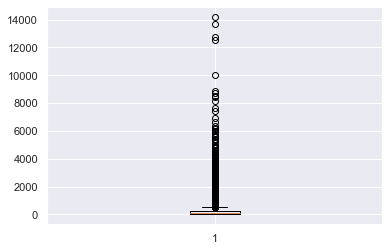

In [30]:
# groupby('user_id').count() gives us each user's number of ratings.
# If a user rated too many anime we consider them as outlier. They might be bots
# Or the opposite is also true, some users are crazy enough to create fake accounts and
# boost the anime they are fan of by giving high scores. We will eliminate them.
plt.boxplot(ratings.user_id.value_counts())
plt.show()
# bad

In [31]:
# Detecting and filtering out outlier users 
# some users have more than necessary ratings (max user has 15000 ratings. might be even
# a bot, or a real weeb :) and some have very few reviews. we don't want to include them.
temp_df = ratings.user_id.value_counts() # df that holds num of rating for each user

IQR = temp_df.quantile(q=0.75) - temp_df.quantile(q=0.25)
u_bound = (temp_df.quantile(q=0.75) + 1.5*IQR)
l_bound = (temp_df.quantile(q=0.25) - 1.5*IQR)
outlier_filter = temp_df.between(left=l_bound, right=u_bound)


print(f"Before outlier removal user num: {len(temp_df.index)}")
print(f"Before outlier removal rating num: {len(ratings.index)}")
print(f"Before outlier removal rated anime num:\
    {len(ratings.anime_id.value_counts().index)}")
print("########################################################")
print("####################   Outlier Removal   ###############")
print("########################################################")
ratings = ratings[ratings['user_id'].isin((temp_df[outlier_filter]).index)] # filtering

print(f"After outlier removal user num: {len(temp_df[outlier_filter].index)}")
print(f"After outlier removal rating num: {len(ratings.index)}")
print(f"After outlier removal rated anime num:\
    {len(ratings.anime_id.value_counts().index)}")
del temp_df
del outlier_filter
del IQR
del u_bound
del l_bound

Before outlier removal user num: 309486
Before outlier removal rating num: 56727080
Before outlier removal rated anime num:    15553
########################################################
####################   Outlier Removal   ###############
########################################################
After outlier removal user num: 289535
After outlier removal rating num: 39653886
After outlier removal rated anime num:    13530


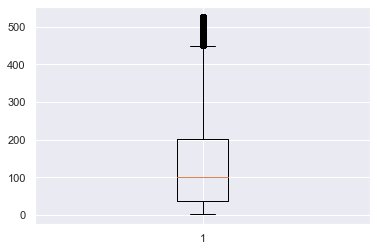

In [32]:
plt.boxplot(ratings.user_id.value_counts())
plt.show()
# better

But there are still users with one or really less number of ratings. They will not provide us any (or very very little) information.

#### Selecting ratings

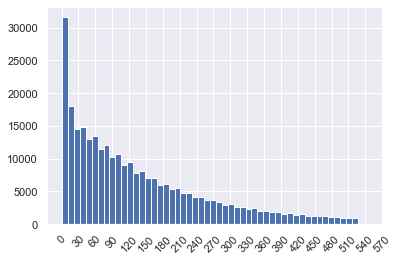

count    289535.000000
mean        136.957142
std         123.338623
min           1.000000
25%          38.000000
50%         101.000000
75%         203.000000
max         527.000000
Name: user_id, dtype: float64

In [33]:
plt.hist(ratings['user_id'].value_counts(),bins=50)
plt.xticks(np.arange(0,600,30), rotation=45)
plt.show()
ratings['user_id'].value_counts().describe()

In [34]:
temp_df = ratings.user_id.value_counts()
temp_rating_filter = temp_df > 39
ratings = ratings[ratings['user_id'].isin((temp_df[temp_rating_filter]).index)]
del temp_rating_filter, temp_df

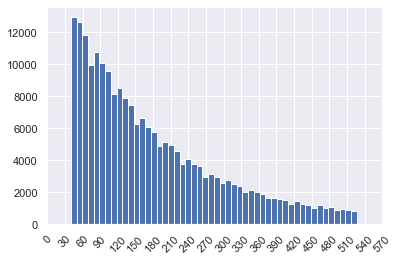

count    215772.000000
mean        178.204962
std         116.990818
min          40.000000
25%          84.000000
50%         145.000000
75%         244.000000
max         527.000000
Name: user_id, dtype: float64

In [35]:
plt.hist(ratings['user_id'].value_counts(),bins=50)
plt.xticks(np.arange(0,600,30), rotation=45)
plt.show()
ratings['user_id'].value_counts().describe()

#### Selecting ratings again: this time for animes that are rated really few times

In [36]:
ratings['anime_id'].value_counts().describe()

count     13503.000000
mean       2847.636896
std        8844.221792
min           1.000000
25%          10.000000
50%         135.000000
75%        1381.000000
max      145196.000000
Name: anime_id, dtype: float64

In [37]:
print(f"Before non populer anime removal user num: {len(ratings.user_id.value_counts().index)}")
print(f"Before non populer anime removal rating num: {len(ratings.index)}")
print(f"Before non populer anime removal rated anime num: {len(ratings.anime_id.value_counts().index)}")

temp_df = ratings['anime_id'].value_counts()
anime_filter = temp_df.quantile(0.2, interpolation='nearest')
temp_df = temp_df[temp_df > int(anime_filter)]
ratings = ratings[ratings['anime_id'].isin(temp_df.index)]

print("\n")
print(f"After non populer anime removal user num: {len(temp_df.index)}")
print(f"After non populer anime removal rating num: {len(ratings.index)}")
print(f"After non populer anime removal rated anime num: {len(temp_df.index)}")
del temp_df, anime_filter


Before non populer anime removal user num: 215772
Before non populer anime removal rating num: 38451641
Before non populer anime removal rated anime num: 13503


After non populer anime removal user num: 9437
After non populer anime removal rating num: 38429723
After non populer anime removal rated anime num: 9437


#### Normalizing Ratings

In [38]:
scaler = preprocessing.MinMaxScaler()
ratings['rating'] = scaler.fit_transform(np.array(ratings['rating']).reshape(-1,1))
del scaler

### <b>2.c Anime: Selecting Animes (Filter Out Really Unpopuler or Unloved Ones)</b>

#### Removing animes that are not rated (not in the ratings df) 

In [39]:
# we have anime info in 'animes' dataframe (readed csv in previous steps)
print(f"Before filtering by ratings, anime num in anime info df: {len(animes.index)}")
animes = animes[animes['anime_id'].isin(set(ratings.anime_id))]
print(f"After filtering by ratings, anime num in anime info df: {len(animes.index)}")

Before filtering by ratings: 16217
After filtering by ratings: 9437


#### Feature Engineering
Trying to get two measures: How relevant anime is and how loved is it.

In [40]:
## These two features will be used in relevancy

w = preprocessing.normalize([np.array(animes['watching'])])
p = preprocessing.normalize([np.array(animes['plan_to_watch'])])
o = preprocessing.normalize([np.array(animes['on_hold'])])
c = preprocessing.normalize([np.array(animes['completed'])])
d = preprocessing.normalize([np.array(animes['dropped'])]) # user changed mind and didn't watch: negative

s = preprocessing.normalize([np.array(animes['score'].fillna(0))])
pp = preprocessing.normalize([1 / np.array(animes['popularity'].fillna(0))])
m = preprocessing.normalize([np.array(animes['members'].fillna(0))])
f = preprocessing.normalize([np.array(animes['favorites'].fillna(0))])
h = preprocessing.normalize([np.array(animes[['score_3', 'score_2', 'score_1']].sum(axis=1))]) # gave really low score: negative

# How many users rated that anime: rate count
rc = preprocessing.normalize([np.array(animes.loc[:,"score_10":"score_1"].sum(axis=1))])
# How many users watched this anime (currently watching, counts more in relevancy): view rate 
vr = w[0] + 0.8*p[0] + 0.6*o[0] + 0.4*c[0] + 0.4*d[0]
vr = preprocessing.normalize([vr])
relevancy_score = vr[0] + rc[0]
relevancy_score = preprocessing.normalize([relevancy_score])
animes['relevancy_score'] = relevancy_score[0]


## This features will be used in love_score
love_score = f[0] + 0.8*pp[0] + 0.6*m[0] + 0.4*s[0] - 0.4*d[0] - 0.8*h[0]
love_score = preprocessing.normalize([love_score])
animes['love_score'] = love_score[0]

# dropping other unnecessary columns
del c,w,p,o,d,s,pp,m,f,h,rc,vr,relevancy_score,love_score
animes.drop(columns=['ranked'],inplace=True) # this is already an index based on score, corr=-1 nearly
animes.drop(columns=['watching', 'completed', 'on_hold', 'dropped', 'plan_to_watch'],inplace=True)
animes.drop(columns=['score_10', 'score_9', 'score_8', 'score_7', 'score_6',
       'score_5', 'score_4', 'score_3', 'score_2', 'score_1'],inplace=True)
animes.drop(columns=['score', 'popularity', 'members', 'favorites'],inplace=True)

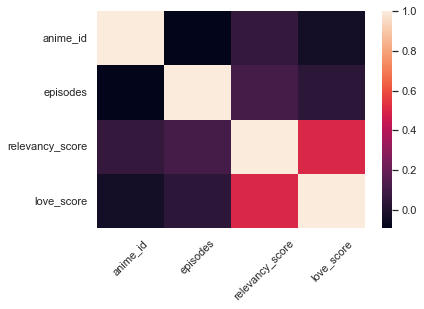

In [41]:
sns.heatmap(animes.corr())
plt.xticks(rotation=45)
plt.show()

In [42]:
animes.corr()
# Not that bad for relevancy and love score correlation, we should've already expected
# that these two scores would be correlated a bit. High correlation would make our 
# 'good animes to consider' filter too wide low correlation would make the opposite
# I belive where these two metrics are currently is good

,anime_id,episodes,relevancy_score,love_score
anime_id,1.000000,-0.094321,0.058557,-0.036316
episodes,-0.094321,1.000000,0.106549,0.037110
relevancy_score,0.058557,0.106549,1.000000,0.502001
love_score,-0.036316,0.037110,0.502001,1.000000


<b>Filtering Animes</b>

In [43]:
filt_1 = animes['love_score']>animes['love_score'].quantile(0.10) # filter based on love score
filt_2 = animes['relevancy_score']>animes['relevancy_score'].quantile(0.10) # filter based on relevancy score (how alive it is)
print("Before the filter, the number of anime is: ",len(animes))
animes = animes[filt_1 & filt_2]
print("After the filter, the number of anime is: ",len(animes))
del filt_1, filt_2

Before the filter, the number of anime is:  9437
After the filter, the number of anime is:  5871


### <b>2.d Creating User-Item Matrix</b>

In [44]:
# only consider ratings that are in animes dataframe (for collaborative and content based filter consistency)
ratings = ratings[ratings.anime_id.isin(animes.anime_id)]

x = len(ratings.groupby('user_id'))
y = len(ratings.groupby('anime_id'))

user_id_decoding = {i:x for i,x in enumerate(ratings['user_id'].unique())}
user_id_encoding = {x:i for i,x in enumerate(ratings['user_id'].unique())}

anime_id_decoding = {i:x for i,x in enumerate(ratings['anime_id'].unique())}
anime_id_encoding = {x:i for i,x in enumerate(ratings['anime_id'].unique())}
ratings.user_id = ratings.user_id.map(user_id_encoding)
ratings.anime_id = ratings.anime_id.map(anime_id_encoding)
ratings = np.array(ratings)


In [45]:
# This step takes a bit long even with threading (approx 3-5 minutes)
import concurrent.futures
user_item_matrix = np.zeros((x, y)) # init empty matrix

def create_user_item_matrix(anime):
    global user_item_matrix
    users = np.arange(0,x) # represents users (since ids are mapped to 0-x)
    anime_rating_v = ratings[ratings[:,1] == anime] # ratings vector that include that particular anime id (given in the func param)
    # assign users (which gave that rating) rating in the matrix to that rating 
    user_item_matrix[np.isin(users, anime_rating_v[:,0]), anime] = anime_rating_v[:,2] 

with concurrent.futures.ThreadPoolExecutor() as executer:
    for anime in np.unique(ratings[:,1]).astype(int): # For unique anime ids in the ratings df
        executer.submit(create_user_item_matrix, anime) # submit that execution of func with the param

np.save("data_cleansed/user_item_matrix.npy",user_item_matrix)
# IMPORTANT: we are getting rid of 'ratings' since we now have user-item matrix
# we also removed user-item matrix as we've saved it into our hard disc
del anime, executer, ratings, x, y, user_item_matrix

### Creating Labels for Anime Genres

## <b> Model Building </b>